# ConvNext training complete pipeline

## 0. Import libraries

In [121]:
import os
from pathlib import Path
from typing import List, Tuple
from shutil import copy2
from PIL import Image

import cv2
import numpy as np
import pandas as pd
import torch as pt
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as T
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Try to import Lion optimizer
try:
    from lion_pytorch import Lion
    print("✅ Lion optimizer available")
except ImportError:
    print("⚠️ Installing Lion optimizer...")
    !pip install lion-pytorch
    from lion_pytorch import Lion
    print("✅ Lion optimizer installed")

%matplotlib inline

# select device
if pt.cuda.is_available():
    device = 'cuda'
elif pt.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'


print(f"Pytorch version: {pt.__version__}")
print(f"Using device: {device}")
print(f"OpenCV version: {cv2.__version__}")

✅ Lion optimizer available
Pytorch version: 2.9.1
Using device: mps
OpenCV version: 4.12.0


In [122]:
RANDOM_SEED = 42

In [123]:
def set_seed(seed: int = 42) -> None:
    """Set seed for reproducibility."""
    np.random.seed(seed)
    pt.manual_seed(seed)
    if pt.cuda.is_available():
        pt.cuda.manual_seed(seed)
        pt.cuda.manual_seed_all(seed)
    elif pt.backends.mps.is_available():
        pt.mps.manual_seed(seed)

In [124]:
set_seed(RANDOM_SEED)

## 1. Dataset Preprocessing

We have to filter out shrek and goo artifacts from dataset. Use masks by cropping the images to the masks bounding box and then apply patching technique and create multiple images from one image, use 128x128 imsize for the patches.

In [125]:
MAX_ARTIFACT_RATIO = 0.005  # Maximum allowed artifact ratio
ROOT_DATA_DIR = '../data'
INPUT_DIR = os.path.join(ROOT_DATA_DIR, 'train_data')
TRAIN_LABELS = os.path.join(ROOT_DATA_DIR, 'train_labels.csv')
FILTERED_IMAGES = os.path.join(ROOT_DATA_DIR, 'train_data_filtered')
OUTPUT_DIR = os.path.join(ROOT_DATA_DIR, 'train_data_preprocessed')

In [126]:
train_labels_df = pd.read_csv(TRAIN_LABELS)
print(f"Loaded {len(train_labels_df)} training labels.")

Loaded 691 training labels.


### 1.1 Filter out shrek and goo

In [127]:
def detect_artifacts(image_path, max_artifact_ratio=0.005):
    """
    Detect artifacts using color-based filtering.
    Returns True if image is clean enough, False otherwise.
    """
    img = cv2.imread(image_path)
    if img is None:
        return False, "Failed to load"
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # Define artifact color ranges
    # Green markers
    lower_green = np.array([25, 40, 40])
    upper_green = np.array([95, 255, 255])
    
    # Orange markers
    lower_orange = np.array([5, 50, 50])
    upper_orange = np.array([35, 255, 255])
    
    # White centers
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 30, 255])
    
    # Brown markers
    lower_brown = np.array([0, 60, 20])
    upper_brown = np.array([25, 255, 150])
    
    # Detect all artifacts
    mask_green = cv2.inRange(hsv, lower_green, upper_green)
    mask_orange = cv2.inRange(hsv, lower_orange, upper_orange)
    mask_white = cv2.inRange(hsv, lower_white, upper_white)
    mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)
    
    # Combine all artifact masks
    artifacts = cv2.bitwise_or(mask_green, mask_orange)
    artifacts = cv2.bitwise_or(artifacts, mask_white)
    artifacts = cv2.bitwise_or(artifacts, mask_brown)
    
    # Calculate artifact ratio
    total_pixels = img.shape[0] * img.shape[1]
    artifact_pixels = cv2.countNonZero(artifacts)
    artifact_ratio = artifact_pixels / total_pixels
    
    # Accept if artifact ratio is below threshold
    if artifact_ratio > max_artifact_ratio:
        return False, f"Too many artifacts ({artifact_ratio:.2%})"
    
    return True, f"Clean ({artifact_ratio:.2%} artifacts)"

In [128]:
filtered_images_path = Path(FILTERED_IMAGES)
filtered_images_path.mkdir(parents=True, exist_ok=True)

image_files = train_labels_df["sample_index"].to_list()
filtered_image_files = []

for img_file in tqdm(image_files):
    img_path = Path(INPUT_DIR) / img_file
    mask_path = Path(INPUT_DIR) / img_file.replace('img_', 'mask_')
    is_clean, msg = detect_artifacts(str(img_path), max_artifact_ratio=MAX_ARTIFACT_RATIO)
    if is_clean:
        dest_path = filtered_images_path / img_file
        dest_mask_path = filtered_images_path / img_file.replace('img_', 'mask_')
        copy2(img_path, dest_path)
        copy2(mask_path, dest_mask_path)
        filtered_image_files.append(img_file)

print(f"Filtered images saved to {FILTERED_IMAGES}. {len(filtered_image_files)} clean images found out of {len(image_files)}.")

100%|██████████| 691/691 [00:13<00:00, 49.63it/s]

Filtered images saved to ../data/train_data_filtered. 547 clean images found out of 691.


In [129]:
train_labels_df_filtered = train_labels_df[train_labels_df["sample_index"].isin(filtered_image_files)]
print(f"Filtered training labels: {len(train_labels_df_filtered)} entries.")
train_labels_df_filtered.to_csv(os.path.join(ROOT_DATA_DIR, 'train_labels_filtered.csv'), index=False)

Filtered training labels: 547 entries.


### 2. Augment data by patching

In [130]:
PATCH_SIZE = 128

In [131]:
def crop_image(image: np.ndarray, mask: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Crop image to mask bounding box.
    """
    # Find countours in the mask
    x_coords, y_coords = np.where(mask > 0) 

    # Get bounding box coordinates
    x_min, x_max = np.min(x_coords), np.max(x_coords)
    y_min, y_max = np.min(y_coords), np.max(y_coords)
    
    # Crop image and mask
    cropped_image = image[x_min:x_max+1, y_min:y_max+1]
    cropped_mask = mask[x_min:x_max+1, y_min:y_max+1]
    
    return cropped_image, cropped_mask
    

def extract_patches(image: np.ndarray, mask: np.ndarray, patch_size: int, overlap: int) -> List[Tuple[np.ndarray, np.ndarray]]:
    """
    Extract patches with overlap, handling edges by ensuring full coverage.
    """
    patches = []
    img_height, img_width = image.shape[:2]
    stride = patch_size - overlap

    # Calculate positions (ensuring we capture edges)
    y_positions = list(range(0, img_height - patch_size + 1, stride))
    x_positions = list(range(0, img_width - patch_size + 1, stride))
    
    # Add edge positions if not already included
    if img_height >= patch_size:
        if y_positions[-1] != img_height - patch_size:
            y_positions.append(img_height - patch_size)
    else:
        y_positions = [0]
    if img_width >= patch_size:
        if x_positions[-1] != img_width - patch_size:
            x_positions.append(img_width - patch_size)
    else:
        x_positions = [0]
    
    # Extract patches
    for i in y_positions:
        for j in x_positions:
            if img_height < patch_size:
                i_end = img_height
            else:
                i_end = i + patch_size    
            if img_width < patch_size:
                j_end = img_width
            else:
                j_end = j + patch_size
            img_patch = image[i:i_end, j:j_end]
            mask_patch = mask[i:i_end, j:j_end]
            
            # Skip patches with insufficient tissue
            if np.count_nonzero(mask_patch) < 0.1 * patch_size * patch_size:
                continue
            
            patches.append((img_patch, mask_patch))
    
    return patches
    

In [140]:
output_dir_path = Path(OUTPUT_DIR)
output_dir_path.mkdir(parents=True, exist_ok=True)

n_patches = 0

rows = {"sample_index": [], "patch": [], "label": []}

filtered_image_files = train_labels_df_filtered["sample_index"].to_list()
filtered_image_labels  = train_labels_df_filtered["label"].to_list()

for img_file, label in tqdm(zip(filtered_image_files, filtered_image_labels), total=len(filtered_image_files)):
    img_path = Path(FILTERED_IMAGES) / img_file
    mask_path = Path(FILTERED_IMAGES) / img_file.replace('img_', 'mask_')
    
    # Load image and mask
    image = cv2.imread(str(img_path))
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    
    # Crop to bounding box
    cropped_image, cropped_mask = crop_image(image, mask)
    
    # Extract patches
    patches = extract_patches(cropped_image, cropped_mask, PATCH_SIZE, overlap=32)
    
    # Save patches
    base_name = img_file.replace('img_', '').replace('.png', '')
    for idx, (img_patch, mask_patch) in enumerate(patches):
        patch_img_path = Path(OUTPUT_DIR) / f"img_{base_name}_patch{idx:03d}.png"
        patch_mask_path = Path(OUTPUT_DIR) / f"mask_{base_name}_patch{idx:03d}.png"
        cv2.imwrite(str(patch_img_path), img_patch)
        cv2.imwrite(str(patch_mask_path), mask_patch)
        rows["sample_index"].append(img_file)
        rows["patch"].append(patch_img_path.name)
        rows["label"].append(label)
    n_patches += len(patches)

print(f"Preprocessed patches saved to {OUTPUT_DIR}. Total patches extracted: {n_patches}.")

100%|██████████| 547/547 [00:13<00:00, 40.49it/s]

Preprocessed patches saved to ../data/train_data_preprocessed. Total patches extracted: 4417.


In [141]:
rows

{'sample_index': ['img_0000.png',
  'img_0002.png',
  'img_0002.png',
  'img_0002.png',
  'img_0002.png',
  'img_0003.png',
  'img_0003.png',
  'img_0003.png',
  'img_0003.png',
  'img_0003.png',
  'img_0004.png',
  'img_0004.png',
  'img_0006.png',
  'img_0006.png',
  'img_0006.png',
  'img_0006.png',
  'img_0007.png',
  'img_0007.png',
  'img_0009.png',
  'img_0009.png',
  'img_0009.png',
  'img_0009.png',
  'img_0009.png',
  'img_0009.png',
  'img_0009.png',
  'img_0009.png',
  'img_0009.png',
  'img_0009.png',
  'img_0009.png',
  'img_0009.png',
  'img_0009.png',
  'img_0009.png',
  'img_0009.png',
  'img_0009.png',
  'img_0009.png',
  'img_0009.png',
  'img_0009.png',
  'img_0010.png',
  'img_0010.png',
  'img_0011.png',
  'img_0011.png',
  'img_0011.png',
  'img_0011.png',
  'img_0011.png',
  'img_0011.png',
  'img_0013.png',
  'img_0013.png',
  'img_0013.png',
  'img_0013.png',
  'img_0013.png',
  'img_0013.png',
  'img_0013.png',
  'img_0013.png',
  'img_0013.png',
  'img_0014.

In [142]:
train_labels_patches = pd.DataFrame(rows, columns=['sample_index', 'patch', 'label'])
train_labels_patches.to_csv(os.path.join(ROOT_DATA_DIR, 'train_labels_preprocessed_patches.csv'), index=False)

In [143]:
train_labels_patches.head()

,sample_index,patch,label
0,img_0000.png,img_0000_patch000.png,Triple negative
1,img_0002.png,img_0002_patch000.png,Luminal B
2,img_0002.png,img_0002_patch001.png,Luminal B
3,img_0002.png,img_0002_patch002.png,Luminal B
4,img_0002.png,img_0002_patch003.png,Luminal B


## 3. Training

### 3.1 Dataset class setup

In [176]:
class ConvNeXtDataset(Dataset):
    def __init__(self, image_dir: str, labels_df: pd.DataFrame, class_names: List[str], transform=None):
        self.image_dir = Path(image_dir)
        self.labels_df = labels_df.set_index('patch')
        self.transform = transform
        self.patch_files = list(self.labels_df.index)
        self.class_names = class_names

    def __len__(self):
        return len(self.patch_files)

    def __getitem__(self, idx):
        patch_file = self.patch_files[idx]
        patch_path = self.image_dir / patch_file
        image = Image.open(patch_path).convert('RGB')
        
        label = self.labels_df.loc[patch_file, 'label']
        class_num = self.class_names.index(label)
        
        if self.transform:
            image = self.transform(image)
        
        return image, class_num

### 3.2 Transformations

In [156]:
# Configuration
IMG_SIZE = 128
BATCH_SIZE = 32  # Larger for BatchNorm stability (Advice 04/12)
NUM_WORKERS = 0

# Training transforms with RandAugment (Advice 06/12)
train_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomVerticalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.RandAugment(num_ops=2, magnitude=7),  # Automated augmentation
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation transforms (no augmentation)
val_transform = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### 3.3 Set up datasets and dataloaders

#### Split dataset to train and validation set

In [157]:
# Split based on image index to avoid data leakage
train_sample_indices, val_sample_indices= train_test_split(
    train_labels_patches['sample_index'].unique(), 
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=train_labels_patches.drop_duplicates(subset=['sample_index'])['label']
)

#TODO: verify if splitting is correct
train_df = train_labels_patches[train_labels_patches['sample_index'].isin(train_sample_indices)]
val_df = train_labels_patches[train_labels_patches['sample_index'].isin(val_sample_indices)]

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}")

Training samples: 3508, Validation samples: 909


In [158]:
train_df.head()

,sample_index,patch,label
0,img_0000.png,img_0000_patch000.png,Triple negative
1,img_0002.png,img_0002_patch000.png,Luminal B
2,img_0002.png,img_0002_patch001.png,Luminal B
3,img_0002.png,img_0002_patch002.png,Luminal B
4,img_0002.png,img_0002_patch003.png,Luminal B


In [159]:
val_df.head()

,sample_index,patch,label
0,img_0006.png,img_0006_patch000.png,Luminal A
1,img_0006.png,img_0006_patch001.png,Luminal A
2,img_0006.png,img_0006_patch002.png,Luminal A
3,img_0006.png,img_0006_patch003.png,Luminal A
4,img_0014.png,img_0014_patch000.png,HER2(+)


In [160]:
# Check if there is no data leakage between train and val sets
train_sample_set = set(train_df['sample_index'].unique())
val_sample_set = set(val_df['sample_index'].unique())
overlap = train_sample_set.intersection(val_sample_set)
print(f"Data leakage check - overlapping sample indices: {len(overlap)}")  #

Data leakage check - overlapping sample indices: 0


### Calculate class weights

In [161]:
class_counts = train_df['label'].value_counts()
class_counts

label
Luminal B          1290
Luminal A           952
HER2(+)             902
Triple negative     364
Name: count, dtype: int64

### Create dataset objects and dataloaders

In [177]:
ALL_CLASS_NAMES = sorted(train_labels_patches['label'].unique())
print(f"All class names: {ALL_CLASS_NAMES}")

train_ds = ConvNeXtDataset(
    image_dir=OUTPUT_DIR, labels_df=train_df, class_names=ALL_CLASS_NAMES, transform=train_transform
)
val_ds = ConvNeXtDataset(
    image_dir=OUTPUT_DIR, labels_df=val_df, class_names=ALL_CLASS_NAMES, transform=val_transform
)

print(f"Train classes: {train_ds.class_names}")
print(f"Validation classes: {val_ds.class_names}")
assert train_ds.class_names == val_ds.class_names, "Class names do not match between train and val datasets!"

All class names: ['HER2(+)', 'Luminal A', 'Luminal B', 'Triple negative']
Train classes: ['HER2(+)', 'Luminal A', 'Luminal B', 'Triple negative']
Validation classes: ['HER2(+)', 'Luminal A', 'Luminal B', 'Triple negative']


In [164]:
train_ds[0][0].size()

torch.Size([3, 128, 128])

In [ ]:
train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)
val_dl = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

## 4 Model Setup

In [180]:
model = convnext_tiny(weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
num_classes = len(train_ds.class_names)

# Modify the final layer for our number of classes
model.classifier[2] = nn.Linear(in_features=768, out_features=num_classes)

# Init layers properly
nn.init.xavier_uniform_(model.classifier[2].weight)
nn.init.zeros_(model.classifier[2].bias)

model.to(device)

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [181]:
# Lion optimizer (Advice 07/12)

# Calculate class weights for loss function
class_counts = train_df['label'].value_counts()
print(f"Class distribution:\n{class_counts}")

total_samples = len(train_df)

class_weights_list = []
for label in ALL_CLASS_NAMES:
    if label in class_counts:
        weight = total_samples / (len(class_counts) * class_counts[label]) 
    else:
        weight = 0.0  # Assign zero weight if class not present
    class_weights_list.append(weight)
    
class_weights_tensor = pt.tensor(class_weights_list, dtype=pt.float32).to(device)

print("Class weights (in model output order):")
for class_name, weight in zip(ALL_CLASS_NAMES, class_weights_list):
    print(f"  {class_name}: {weight:.4f}")

# Loss with label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.05, weight=class_weights_tensor)


# Lion needs 3-10x smaller LR than Adam
optimizer = Lion(model.parameters(), lr=1e-4, weight_decay=1e-2)

# Cosine annealing scheduler
scheduler = pt.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

Class distribution:
label
Luminal B          1290
Luminal A           952
HER2(+)             902
Triple negative     364
Name: count, dtype: int64
Class weights (in model output order):
  HER2(+): 0.9723
  Luminal A: 0.9212
  Luminal B: 0.6798
  Triple negative: 2.4093


## 5. Training loop

### Training function definitions

In [178]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0
    all_preds = []
    all_labels = []

    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, preds = pt.max(outputs, 1)
        correct_preds += (preds == labels).sum().item()
        total_samples += images.size(0)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_preds / total_samples
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')
    return epoch_loss, epoch_acc, epoch_f1

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0
    all_preds = []
    all_labels = []
    
    with pt.no_grad():
        for images, labels in tqdm(dataloader, desc="Validation", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = pt.max(outputs, 1)
            correct_preds += (preds == labels).sum().item()
            total_samples += images.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Debug: Check prediction distribution
    unique, counts = np.unique(all_preds, return_counts=True)
    print(f" Prediction classes: {unique.tolist()} with counts: {counts.tolist()}")
            
    epoch_loss = running_loss / total_samples
    epoch_acc = correct_preds / total_samples
    epoch_f1 = f1_score(all_labels, all_preds, average='macro')
    return epoch_loss, epoch_acc, epoch_f1

### Training configuration

In [169]:
NUM_EPOCHS = 3
WARMUP_EPOCHS = 3
PATIENCE = 10

# Freeze backbone for initial epochs
for param in model.features.parameters():
    param.requires_grad = False

In [182]:
# 2. Check class distribution
print(f"\n2️⃣ Class distribution:")
for i, label in enumerate(ALL_CLASS_NAMES):
    train_count = (train_df['label'] == label).sum()
    val_count = (val_df['label'] == label).sum()
    weight = class_weights_list[i]
    print(f"   [{i}] {label:20s}: train={train_count:4d}, val={val_count:4d}, weight={weight:.3f}")



2️⃣ Class distribution:
   [0] HER2(+)             : train= 902, val= 231, weight=0.972
   [1] Luminal A           : train= 952, val= 225, weight=0.921
   [2] Luminal B           : train=1290, val= 354, weight=0.680
   [3] Triple negative     : train= 364, val=  99, weight=2.409


In [183]:
# 3. Test model output
print(f"\n3️⃣ Model output test:")
model.eval()
with pt.no_grad():
    sample_batch = next(iter(train_dl))
    images, labels = sample_batch
    images = images.to(device)
    outputs = model(images)
    print(f"   Input shape:  {images.shape}")
    print(f"   Output shape: {outputs.shape}")
    print(f"   Expected:     {(BATCH_SIZE, num_classes)}")
    assert outputs.shape == (images.shape[0], num_classes)
    
    # Check if all classes are possible
    probs = pt.softmax(outputs, dim=1)
    max_probs = probs.max(dim=0).values
    min_probs = probs.min(dim=0).values
    print(f"   Max prob per class: {max_probs.cpu().numpy()}")
    print(f"   Min prob per class: {min_probs.cpu().numpy()}")
    
    # Check predictions
    _, preds = pt.max(outputs, 1)
    unique_preds = pt.unique(preds)
    print(f"   Predicted classes in batch: {unique_preds.cpu().tolist()}")
    if len(unique_preds) == 1:
        print(f"   ⚠️  WARNING: Only predicting class {unique_preds[0].item()}!")



3️⃣ Model output test:


/Users/bencegaborpeter/Polimi/AN2DL/Challenges/AN2DL_Image_Classification/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


   Input shape:  torch.Size([32, 3, 128, 128])
   Output shape: torch.Size([32, 4])
   Expected:     (32, 4)
   Max prob per class: [0.38516477 0.63881147 0.75620425 0.28605357]
   Min prob per class: [0.02820363 0.06626482 0.20279111 0.03034775]
   Predicted classes in batch: [0, 1, 2, 3]


In [170]:
print("FROZEN PARAMETERS:")
for name, param in model.named_parameters():
    if not param.requires_grad:
        print(name)

print("TRAINABLE PARAMETERS:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

FROZEN PARAMETERS:
features.0.0.weight
features.0.0.bias
features.0.1.weight
features.0.1.bias
features.1.0.layer_scale
features.1.0.block.0.weight
features.1.0.block.0.bias
features.1.0.block.2.weight
features.1.0.block.2.bias
features.1.0.block.3.weight
features.1.0.block.3.bias
features.1.0.block.5.weight
features.1.0.block.5.bias
features.1.1.layer_scale
features.1.1.block.0.weight
features.1.1.block.0.bias
features.1.1.block.2.weight
features.1.1.block.2.bias
features.1.1.block.3.weight
features.1.1.block.3.bias
features.1.1.block.5.weight
features.1.1.block.5.bias
features.1.2.layer_scale
features.1.2.block.0.weight
features.1.2.block.0.bias
features.1.2.block.2.weight
features.1.2.block.2.bias
features.1.2.block.3.weight
features.1.2.block.3.bias
features.1.2.block.5.weight
features.1.2.block.5.bias
features.2.0.weight
features.2.0.bias
features.2.1.weight
features.2.1.bias
features.3.0.layer_scale
features.3.0.block.0.weight
features.3.0.block.0.bias
features.3.0.block.2.weight

In [175]:
training_history = {
    'train_loss': [],
    'train_f1': [],
    'train_acc': [],
    'val_loss': [],
    'val_f1': [],
    'val_acc': [],
}

best_val_f1 = 0.0
epochs_no_improve = 0

for epoch in range(NUM_EPOCHS):
    if epoch == WARMUP_EPOCHS:
        print("Unfreezing backbone...")
        for param in model.features.parameters():
            param.requires_grad = True
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    train_loss, train_acc, train_f1 = train_one_epoch(model, train_dl, criterion, optimizer, device)
    val_loss, val_acc, val_f1 = validate_one_epoch(model, val_dl, criterion, device)
    scheduler.step()
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
    print(f"Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}, Val   F1: {val_f1:.4f}")
    training_history['train_loss'].append(train_loss)
    training_history['train_acc'].append(train_acc)
    training_history['train_f1'].append(train_f1)
    training_history['val_loss'].append(val_loss)
    training_history['val_acc'].append(val_acc)
    training_history['val_f1'].append(val_f1)
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        epochs_no_improve = 0
        pt.save(model.state_dict(), 'best_model_convnext.pth')
        print("Validation F1 improved, model saved.")
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation F1 for {epochs_no_improve} epochs.")
        if epochs_no_improve >= PATIENCE:
            print("Early stopping triggered.")
            break

Epoch 1/3


Training:   0%|          | 0/110 [00:00<?, ?it/s]/Users/bencegaborpeter/Polimi/AN2DL/Challenges/AN2DL_Image_Classification/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Validation:   0%|          | 0/29 [00:00<?, ?it/s]         /Users/bencegaborpeter/Polimi/AN2DL/Challenges/AN2DL_Image_Classification/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 1.2131, Train Acc: 0.4555, Train F1: 0.4458
Val   Loss: 1.6735, Val   Acc: 0.2376, Val   F1: 0.0357
Validation F1 improved, model saved.
Epoch 2/3


Training:   0%|          | 0/110 [00:00<?, ?it/s]/Users/bencegaborpeter/Polimi/AN2DL/Challenges/AN2DL_Image_Classification/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Validation:   0%|          | 0/29 [00:00<?, ?it/s]         /Users/bencegaborpeter/Polimi/AN2DL/Challenges/AN2DL_Image_Classification/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Train Loss: 1.2076, Train Acc: 0.4723, Train F1: 0.5985
Val   Loss: 1.6578, Val   Acc: 0.2189, Val   F1: 0.0938
Validation F1 improved, model saved.
Epoch 3/3


Training:   0%|          | 0/110 [00:00<?, ?it/s]/Users/bencegaborpeter/Polimi/AN2DL/Challenges/AN2DL_Image_Classification/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Validation:   0%|          | 0/29 [00:00<?, ?it/s]         /Users/bencegaborpeter/Polimi/AN2DL/Challenges/AN2DL_Image_Classification/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
                                                           

Train Loss: 1.2008, Train Acc: 0.4704, Train F1: 0.2548
Val   Loss: 1.6936, Val   Acc: 0.2354, Val   F1: 0.0938
No improvement in validation F1 for 1 epochs.


### Training curves

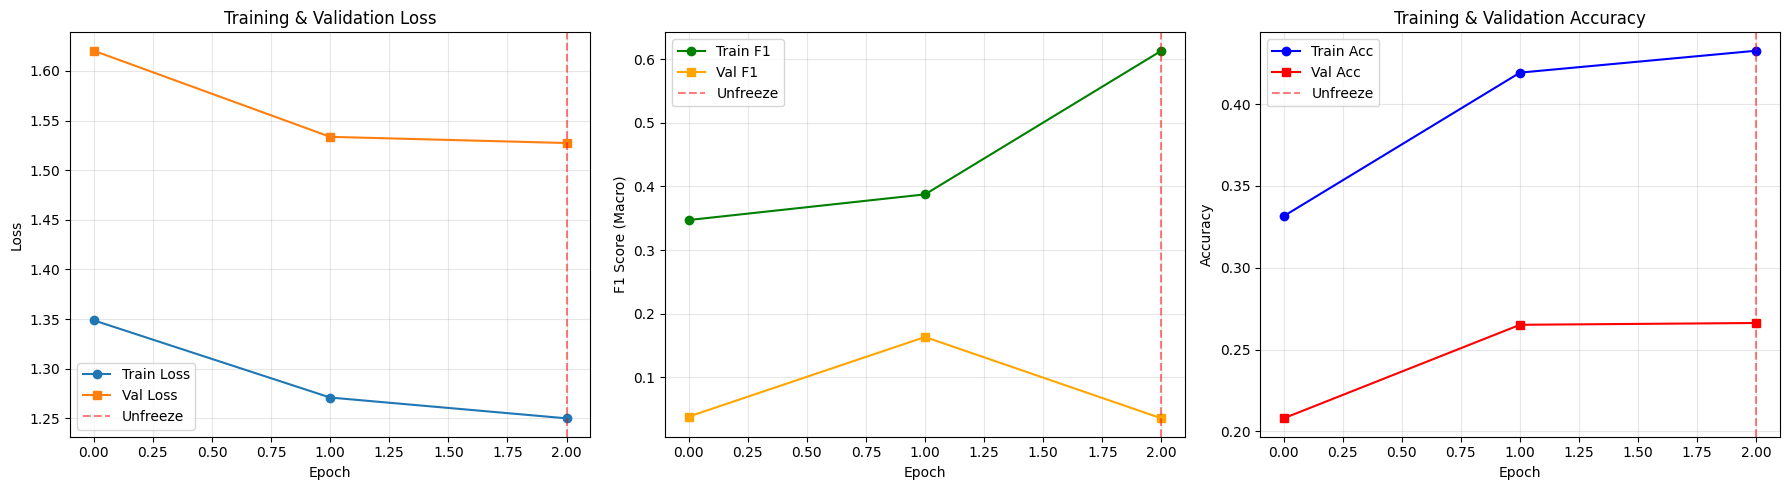

Training curves saved to '../training_curves.png'


In [172]:
# Plot training curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(training_history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(training_history['val_loss'], label='Val Loss', marker='s')
axes[0].axvline(x=WARMUP_EPOCHS-1, color='r', linestyle='--', alpha=0.5, label='Unfreeze')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training & Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# F1 Score
axes[1].plot(training_history['train_f1'], label='Train F1', marker='o', color='green')
axes[1].plot(training_history['val_f1'], label='Val F1', marker='s', color='orange')
axes[1].axvline(x=WARMUP_EPOCHS-1, color='r', linestyle='--', alpha=0.5, label='Unfreeze')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('F1 Score (Macro)')
# axes[1].set_title(f'F1 Score (Best: {best_f1:.4f})')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Accuracy
axes[2].plot(training_history['train_acc'], label='Train Acc', marker='o', color='blue')
axes[2].plot(training_history['val_acc'], label='Val Acc', marker='s', color='red')
axes[2].axvline(x=WARMUP_EPOCHS-1, color='r', linestyle='--', alpha=0.5, label='Unfreeze')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Accuracy')
axes[2].set_title('Training & Validation Accuracy')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training curves saved to '../training_curves.png'")

Evaluating:   0%|          | 0/29 [00:00<?, ?it/s]/Users/bencegaborpeter/Polimi/AN2DL/Challenges/AN2DL_Image_Classification/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
Evaluating: 100%|██████████| 29/29 [00:02<00:00,  9.85it/s]


Classification Report:
                 precision    recall  f1-score   support

      Luminal A       0.18      0.13      0.15       225
        HER2(+)       0.28      0.42      0.34       231
      Luminal B       0.36      0.28      0.32       354
Triple negative       0.12      0.14      0.13        99

       accuracy                           0.27       909
      macro avg       0.24      0.25      0.23       909
   weighted avg       0.27      0.27      0.26       909



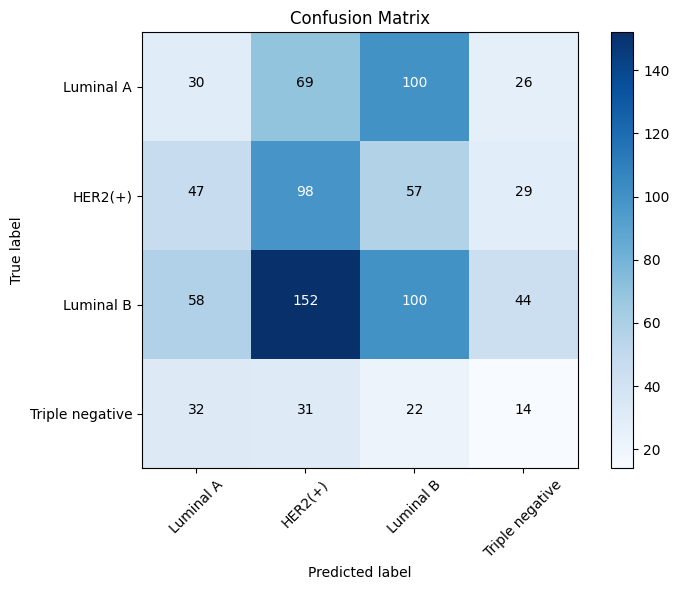

Confusion matrix saved to '../confusion_matrix.png'


In [174]:
model.load_state_dict(pt.load('best_model_convnext.pth'))
model.to(device)
model.eval()

all_preds = []
all_labels = []

with pt.no_grad():
    for images, labels in tqdm(val_dl, desc="Evaluating"):
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images)
        _, preds = pt.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
# Classification report
report = classification_report(all_labels, all_preds, target_names=val_ds.class_names)
print("Classification Report:")
print(report)

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(val_ds.class_names))
plt.xticks(tick_marks, val_ds.class_names, rotation=45)
plt.yticks(tick_marks, val_ds.class_names)

thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig('../confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print("Confusion matrix saved to '../confusion_matrix.png'")

## 6. Run inference on test set
Use patch based inference and do majority voting

### Process test set to create patches

In [118]:
TEST_DATA_DIR = os.path.join(ROOT_DATA_DIR, 'test_data')
test_image_files = sorted(os.listdir(TEST_DATA_DIR))

In [120]:
row = {}

for img_file in tqdm(test_image_files, total=len(test_image_files)):
    if img_file == '.DS_Store':
        continue

    if not img_file.startswith('img_'):
        continue

    img_path = Path(TEST_DATA_DIR) / img_file
    mask_path = Path(TEST_DATA_DIR) / img_file.replace('img_', 'mask_')
    
    # Load image and mask
    image = cv2.imread(str(img_path))
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    
    # Crop to bounding box
    cropped_image, cropped_mask = crop_image(image, mask)
    
    # Extract patches
    patches = extract_patches(cropped_image, cropped_mask, PATCH_SIZE, overlap=32)
    
    # Run inference to get labels
    labels = []

    for idx, (img_patch, mask_patch) in enumerate(patches):
        # Preprocess patch
        pil_img = Image.fromarray(cv2.cvtColor(img_patch, cv2.COLOR_BGR2RGB))
        input_tensor = val_transform(pil_img).unsqueeze(0).to(device)
        
        with pt.no_grad():
            outputs = model(input_tensor)
            _, pred = pt.max(outputs, 1)
            labels.append(val_ds.class_names[pred.item()])
        
    # Majority voting
    if labels:
        final_label = max(set(labels), key=labels.count)
    else:
        final_label = "unknown"
    
    row[img_file] = final_label

submission_df = pd.DataFrame(row.items(), columns=['sample_index', 'label'])
submission_df.to_csv('../submission_convnext.csv', index=False)
print("Submission file saved to '../submission_convnext.csv'")

100%|██████████| 954/954 [00:46<00:00, 20.62it/s]

Submission file saved to '../submission_convnext.csv'
